# Loading the data

In [1]:
import pandas as pd

In [2]:
air_passengers = pd.read_csv('AirPassengers.csv')
air_passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
air_passengers.dtypes

Month          object
#Passengers     int64
dtype: object

In [4]:
air_passengers['Month'] = air_passengers['Month'].astype('datetime64[ns]')
air_passengers['passengers'] = air_passengers['#Passengers'].astype('float64')

In [5]:
air_passengers

,Month,#Passengers,passengers
0,1949-01-01,112,112.0
1,1949-02-01,118,118.0
2,1949-03-01,132,132.0
3,1949-04-01,129,129.0
4,1949-05-01,121,121.0
...,...,...,...
139,1960-08-01,606,606.0
140,1960-09-01,508,508.0
141,1960-10-01,461,461.0
142,1960-11-01,390,390.0


# Looking at the data

In [6]:
from plotnine import *

/home/herwin/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


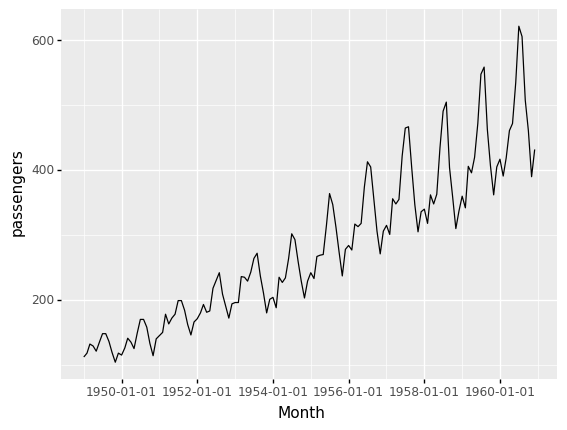

<ggplot: (8772233247763)>

In [7]:
ggplot(air_passengers, aes(x='Month',y='passengers'))+geom_line()

There is an upward trend and the variation gets bigger over time. Getting rid of those by taking the log, then the diff of the data.

In [8]:
import numpy as np
air_passengers['log_passengers'] = np.log(air_passengers['passengers'])
air_passengers['diff_log_passengers'] = air_passengers['log_passengers'].diff()

/home/herwin/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/herwin/anaconda3/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


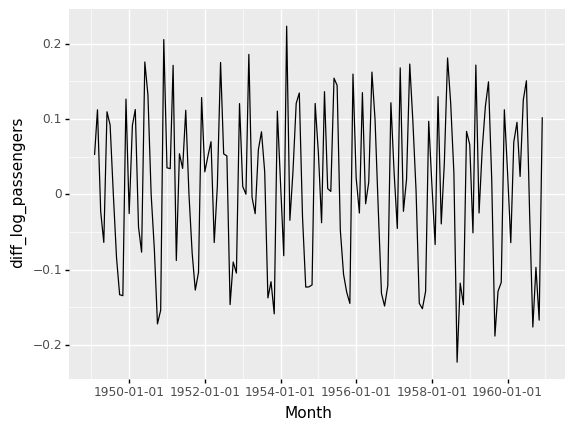

<ggplot: (8772233247748)>

In [9]:
ggplot(air_passengers, aes(x='Month',y='diff_log_passengers'))+geom_line()

The data now seems stationary. Let's take a look at the auto-correlation.

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
air_passengers = air_passengers[1:len(air_passengers)].copy()

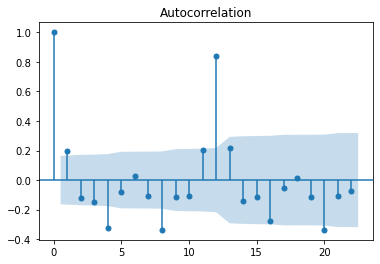

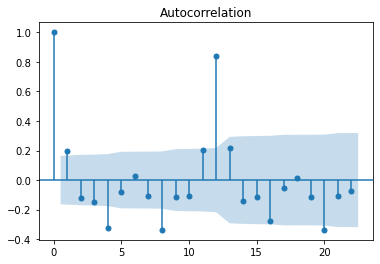

In [12]:
plot_acf(air_passengers['diff_log_passengers'])

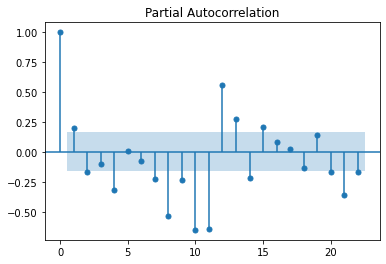

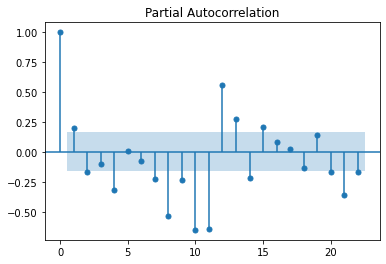

In [13]:
plot_pacf(air_passengers['diff_log_passengers'])

There seems to be a seasonal monthly correlation and some other correlations.

# Fitting a sarima model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
model = SARIMAX(air_passengers['log_passengers'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))

In [16]:
fit = model.fit()

In [17]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     log_passengers   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 252.128
Date:                            Fri, 25 Aug 2023   AIC                           -494.257
Time:                                    15:02:05   BIC                           -479.477
Sample:                                         0   HQIC                          -488.251
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4107      0.167      2.452      0.014       0.082       0.739
ma.L1         -0.7298      0.136     -5.372      0.000      -0.996      -0.464
ar.S.L12       0.9894      0.009    115.139      0.000       0.973       1.006
ma.S.L12      -0.5728      0.110     -5.188      0.000      -0.789      -0.356
sigma2         0.0013      0.000      8.473      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 4.43
Prob(Q):                              0.58   Prob(JB):                         0.11
Heteroskedasticity (H):               0.66   Skew:                             0.03
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
air_passengers['pred'] = fit.predict()

In [22]:
df_plot = air_passengers.melt(id_vars = ['Month'], value_vars=['log_passengers','pred'])
df_plot

,Month,variable,value
0,1949-02-01,log_passengers,4.770685
1,1949-03-01,log_passengers,4.882802
2,1949-04-01,log_passengers,4.859812
3,1949-05-01,log_passengers,4.795791
4,1949-06-01,log_passengers,4.905275
...,...,...,...
281,1960-08-01,pred,6.436306
282,1960-09-01,pred,6.238773
283,1960-10-01,pred,6.108195
284,1960-11-01,pred,6.002224


/home/herwin/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


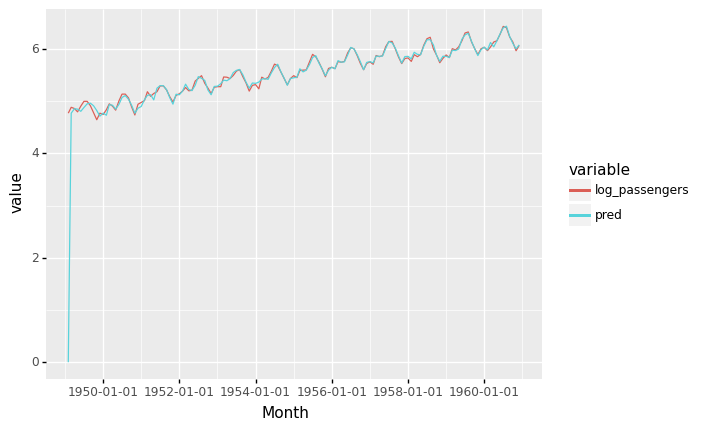

<ggplot: (8772228868244)>

In [23]:
ggplot(df_plot, aes(x='Month',y='value', color='variable'))+geom_line()